In [10]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning

In [ ]:
# Scrape MLB 2024 season data from Sports reference for each team,
# then put it into one table (https://www.sports-reference.com/)

# List of MLB team abbreviations
teams = [
    "ARI", "ATL", "BAL", "BOS", "CHC", "CHW", "CIN", "CLE", "COL", "DET",
    "HOU", "KCR", "LAA", "LAD", "MIA", "MIL", "MIN", "NYM", "NYY", "OAK",
    "PHI", "PIT", "SDP", "SEA", "SFG", "STL", "TBR", "TEX", "TOR", "WSN"
]

# Season year
year = 2024

# Base URL
base_url = "https://www.baseball-reference.com/teams/{TEAM}/{YEAR}-schedule-scores.shtml"

# empty list to store data
all_teams_data = []

# Loop through each team
for team in teams:
    print(f"Fetching data for {team}...")
    try:
        # Construct the URL for the team
        url = base_url.format(TEAM=team, YEAR=year)
        
        # Read the table from the page
        tables = pd.read_html(url)
        
        # Select the main schedule table
        schedule = tables[0]  # Adjust index if necessary
        
        # Add a column for the team
        schedule['Team'] = team
        
        # Append to the list
        all_teams_data.append(schedule)
    except Exception as e:
        print(f"Failed to fetch data for {team}: {e}")

# Combine all teams into one DataFrame
combined_data = pd.concat(all_teams_data, ignore_index=True)

# Save to a CSV file
combined_data.to_csv(f"mlb_{year}_season_data.csv", index=False)

print(f"All team data combined and saved as 'mlb_{year}_season_data.csv'.")

In [4]:
# read in data
mlb_2024 = pd.read_csv('data/mlb_2024_season_data.csv')

# preview - looks like there are header rows in the data
mlb_2024[mlb_2024['Gm#'] == 'Gm#'].head(3)

,Gm#,Date,Unnamed: 2,Tm,Unnamed: 4,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,Team
4,Gm#,April,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,ARI
32,Gm#,May,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,ARI
59,Gm#,June,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,ARI


In [5]:
# Remove header rows from data
mlb_2024_cleaned = mlb_2024[~mlb_2024['Tm'].str.contains('Tm', na=False)]

# confirm it worked
mlb_2024_cleaned[mlb_2024_cleaned['Tm'] == 'Tm']

,Gm#,Date,Unnamed: 2,Tm,Unnamed: 4,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,Team


In [6]:
mlb_2024_cleaned['Unnamed: 4'].value_counts()

Unnamed: 4
@    2429
Name: count, dtype: int64

In [7]:
# drop Unnamed 2, it's just for looking at boxscores on the site
mlb_2024_cleaned = mlb_2024_cleaned.drop(columns=['Unnamed: 2'])

In [9]:
# Rename 'Unnamed: 4' to 'Home?'
mlb_2024_cleaned = mlb_2024_cleaned.rename(columns={'Unnamed: 4': 'Home?'})

# Replace NaN with 'Y' (home games) and '@' with 'N' (away games)
mlb_2024_cleaned['Home?'] = mlb_2024_cleaned['Home?'].apply(lambda x: 'Y' if pd.isna(x) else 'N' if x == '@' else x)

# Check the result
mlb_2024_cleaned.head(3)

,Gm#,Date,Tm,Home?,Opp,W/L,R,RA,Inn,W-L,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,Team
0,1,"Thursday, Mar 28",ARI,Y,COL,W,16,1,NaN,1-0,...,Gallen,Freeland,NaN,2:37,N,49011,.98,+,NaN,ARI
1,2,"Friday, Mar 29",ARI,Y,COL,W,7,3,NaN,2-0,...,Kelly,Quantrill,NaN,2:36,N,29480,1.00,++,NaN,ARI
2,3,"Saturday, Mar 30",ARI,Y,COL,L,4,9,NaN,2-1,...,Lambert,Henry,NaN,3:17,N,32133,1.06,-,NaN,ARI


In [ ]:
# save clean data to csv file
mlb_2024_cleaned.to_csv("mlb_2024_clean.csv", index=False)

# Visualization

Started off with interest in looking just at home win percentages across teams and how they might relate to attendance levels

In [12]:
# Filter for home games only
home_games = mlb_2024_cleaned[mlb_2024_cleaned['Home?'] == 'Y'].copy()

# Group by team and calculate the home win percentage
home_win_percentage = home_games.groupby('Tm')['W/L'].value_counts().unstack()
home_win_percentage['Win Percentage'] = (home_win_percentage['W'] + home_win_percentage['W-wo']) / (home_win_percentage['W'] + home_win_percentage['W-wo'] + home_win_percentage['L'])
home_win_percentage.head(3)

W/L,L,W,W-wo,Win Percentage
Tm,,,,
ARI,37,35,9,0.543210
ATL,35,38,8,0.567901
BAL,37,37,7,0.543210


Going to use each stadium's capacity as a way to normlalize attendanc elevels for each team

In [15]:
# Each team's stadium capacity
stadium_capacities = {
    'OAK': 56782,  # Oakland Athletics
    'LAD': 56000,  # Los Angeles Dodgers
    'ARI': 48405,  # Arizona Diamondbacks
    'SEA': 47929,  # Seattle Mariners
    'COL': 46897,  # Colorado Rockies
    'NYY': 46537,  # New York Yankees
    'LAA': 45517,  # Los Angeles Angels
    'BAL': 44970,  # Baltimore Orioles
    'STL': 44383,  # St. Louis Cardinals
    'CIN': 43500,  # Cincinnati Reds
    'PHI': 42901,  # Philadelphia Phillies
    'TBR': 42735,  # Tampa Bay Rays
    'NYM': 41922,  # New York Mets
    'MIL': 41900,  # Milwaukee Brewers
    'CHC': 41649,  # Chicago Cubs
    'TOR': 41500,  # Toronto Blue Jays
    'WSN': 41339,  # Washington Nationals
    'SFG': 41265,  # San Francisco Giants
    'HOU': 41168,  # Houston Astros
    'ATL': 41084,  # Atlanta Braves
    'DET': 41083,  # Detroit Tigers
    'CHW': 40615,  # Chicago White Sox
    'TEX': 40300,  # Texas Rangers
    'SDP': 40209,  # San Diego Padres
    'PIT': 38747,  # Pittsburgh Pirates
    'MIN': 38544,  # Minnesota Twins
    'KCR': 37903,  # Kansas City Royals
    'BOS': 37755,  # Boston Red Sox
    'MIA': 37442,  # Miami Marlins
    'CLE': 34830   # Cleveland Guardians
}
# Source: https://sports.betmgm.com/en/blog/mlb/biggest-mlb-stadiums-ranking-by-capacity-bm15/

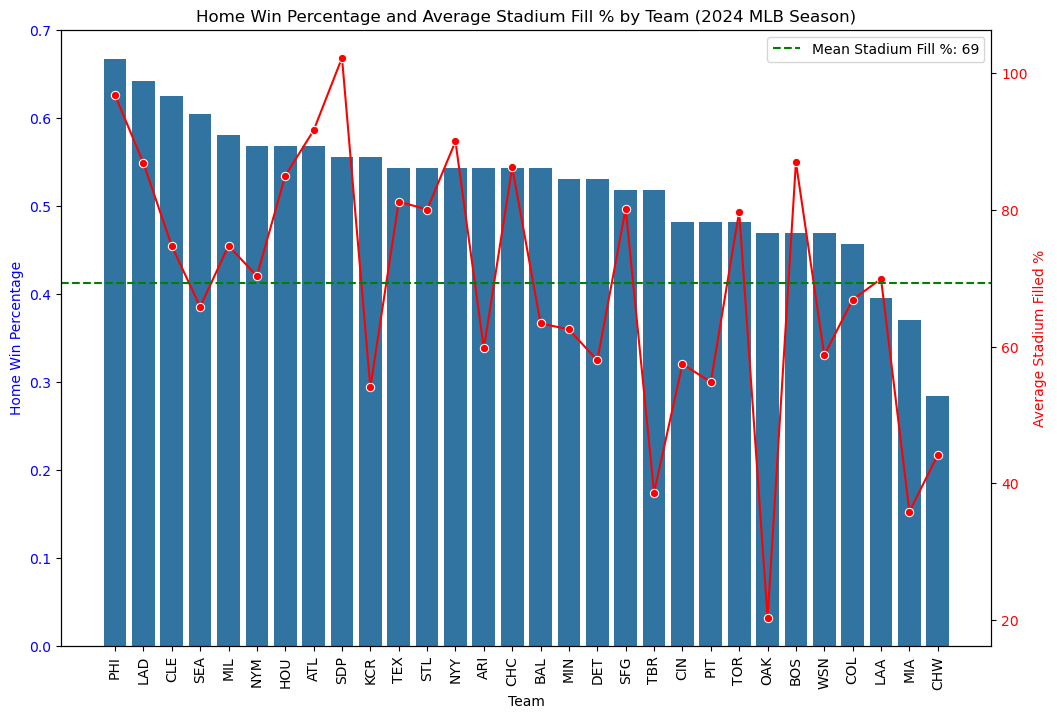

In [17]:
# Filter for home games only
home_games = mlb_2024_cleaned[mlb_2024_cleaned['Home?'] == 'Y'].copy()

# Add stadium capacity to the DataFrame, make numeric
home_games['Stadium Capacity'] = pd.to_numeric(home_games['Tm'].map(stadium_capacities))

# make attendance numeric
home_games['Attendance'] = pd.to_numeric(home_games['Attendance'])

# Calculate percentage of the stadium filled for each game
home_games['Stadium Filled Percent'] = (home_games['Attendance'] / home_games['Stadium Capacity'])*100

# Group by team and calculate the home win percentage
home_win_percentage = home_games.groupby('Tm')['W/L'].value_counts().unstack()
home_win_percentage['Win Percentage'] = (home_win_percentage['W'] + home_win_percentage['W-wo']) / (home_win_percentage['W'] + home_win_percentage['W-wo'] + home_win_percentage['L'])

# Group by team to calculate the average attendance
average_stadium_fill = home_games.groupby('Tm')['Stadium Filled Percent'].mean()

# Merge win percentage and average attendance into one DataFrame
team_stats = home_win_percentage[['Win Percentage']].join(average_stadium_fill)

# Sort the DataFrame by win percentage in descending order
team_stats = team_stats.sort_values(by='Win Percentage', ascending=False)

# Create a subplot for both win percentage and average attendance
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot the home win percentage
sns.barplot(x=team_stats.index, y=team_stats['Win Percentage'], ax=ax1)
ax1.set_xlabel('Team')
ax1.set_ylabel('Home Win Percentage', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation=90)

# Create a secondary y-axis for the average attendance
ax2 = ax1.twinx() # allows for two y-axes to the same x axis
sns.lineplot(x=team_stats.index, y=team_stats['Stadium Filled Percent'], marker='o', color='red', ax=ax2)
ax2.set_ylabel('Average Stadium Filled %', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a dashed line for the mean attendance
mean_stadium_fill = team_stats['Stadium Filled Percent'].mean()
ax2.axhline(mean_stadium_fill, color='green', linestyle='--', label=f'Mean Stadium Fill %: {mean_stadium_fill:,.0f}')
# Add a legend for the dashed line
ax2.legend(loc='upper right')

# Suppress warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.title("Home Win Percentage and Average Stadium Fill % by Team (2024 MLB Season)")
#plt.savefig('home_win_percentage_vs_stadium_fill.png', dpi=300, bbox_inches='tight')
plt.show()

It looks like teams with higher home win percentages do tend to have a higher average stadium filled percentage, as 12 out of the top 15 teams have above average stadium filled %. But is home field advantage causing teams to perform better, or do better performing teams attract greater home crowds?

From here we thought it was a good idea to not just look at home win percentage, but also factor in away win percentage, because some of the teams might just be really good and have high winning percentages whether they're playing home or away. To calculate a home field advantage metric, we decided to take the difference between home win percentage and away win percentage.

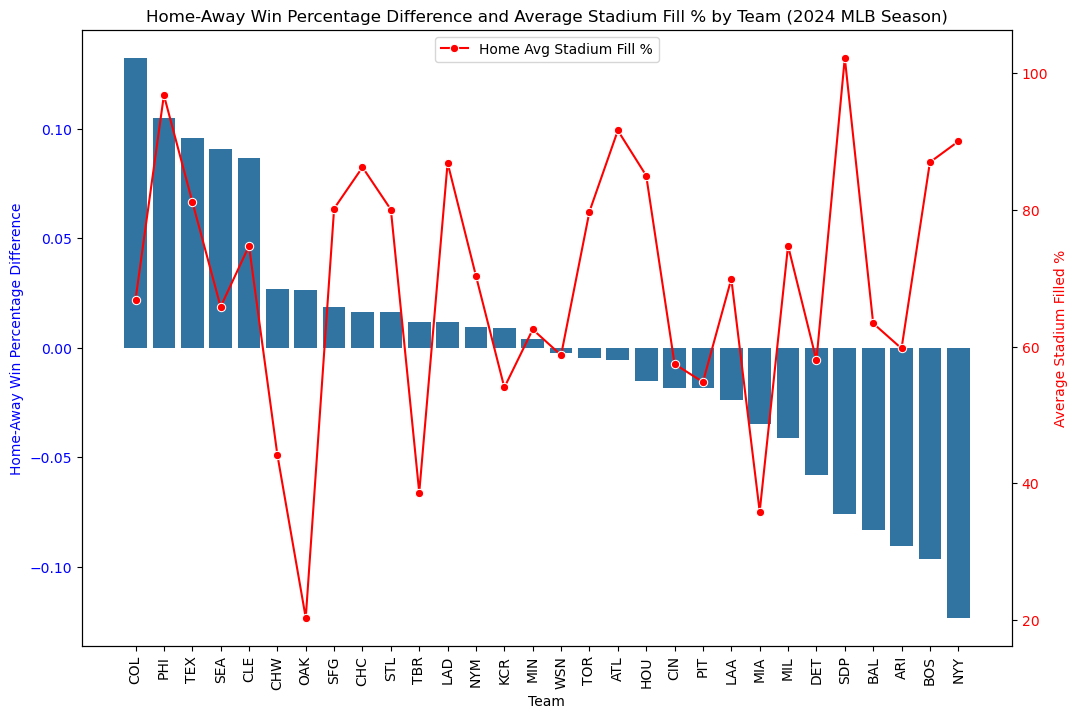

In [21]:
# Filter for home and away games
home_games = mlb_2024_cleaned[mlb_2024_cleaned['Home?'] == 'Y'].copy()
away_games = mlb_2024_cleaned[mlb_2024_cleaned['Home?'] == 'N'].copy()

# Add stadium capacity to the DataFrame for both home and away games, make numeric
home_games['Stadium Capacity'] = pd.to_numeric(home_games['Tm'].map(stadium_capacities))
away_games['Stadium Capacity'] = pd.to_numeric(away_games['Tm'].map(stadium_capacities))

# make attendance numeric
home_games['Attendance'] = pd.to_numeric(home_games['Attendance'])
away_games['Attendance'] = pd.to_numeric(away_games['Attendance'])

# Calculate percentage of the stadium filled for each game
home_games['Stadium Filled Percent'] = (home_games['Attendance'] / home_games['Stadium Capacity']) * 100
away_games['Stadium Filled Percent'] = (away_games['Attendance'] / away_games['Stadium Capacity']) * 100

# Group by team and calculate the home win percentage
home_win_percentage = home_games.groupby('Tm')['W/L'].value_counts().unstack()
home_win_percentage['Win Percentage'] = (home_win_percentage['W'] + home_win_percentage['W-wo']) / (home_win_percentage['W'] + home_win_percentage['W-wo'] + home_win_percentage['L'])

# Group by team and calculate the away win percentage
away_win_percentage = away_games.groupby('Tm')['W/L'].value_counts().unstack()
away_win_percentage['Win Percentage'] = (away_win_percentage['W']) / (away_win_percentage['W'] + away_win_percentage['L'])

# Calculate the difference between home and away win percentages
win_percentage_diff = home_win_percentage['Win Percentage'] - away_win_percentage['Win Percentage']

# Group by team to calculate the average attendance for home games
average_stadium_fill_home = home_games.groupby('Tm')['Stadium Filled Percent'].mean()

# Merge win percentage difference and average stadium fill into one DataFrame
team_stats = pd.DataFrame({
    'Win Percentage Diff': win_percentage_diff,
    'Avg Stadium Fill Home': average_stadium_fill_home,
})

# Sort the DataFrame by win percentage difference in descending order
team_stats = team_stats.sort_values(by='Win Percentage Diff', ascending=False)

# Create a subplot for both win percentage difference and average stadium fill
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot the win percentage difference
sns.barplot(x=team_stats.index, y=team_stats['Win Percentage Diff'], ax=ax1)
ax1.set_xlabel('Team')
ax1.set_ylabel('Home-Away Win Percentage Difference', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation=90)

# Create a secondary y-axis for the average stadium filled percentages for home and away games
ax2 = ax1.twinx()  # allows for dual axis
sns.lineplot(x=team_stats.index, y=team_stats['Avg Stadium Fill Home'], marker='o', color='red', ax=ax2, label='Home Avg Stadium Fill %')
ax2.set_ylabel('Average Stadium Filled %', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a legend
ax2.legend(loc='upper center')

# Suppress warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.title("Home-Away Win Percentage Difference and Average Stadium Fill % by Team (2024 MLB Season)")
plt.show()

This is quite interesting and suggests that the stadium fill percentage really doesn't impact the home-away win percentage difference much at all. If we believe the home-away win percentage difference to be a good representation of home field advantage, then perhaps stadium fill percentage isn't a super important characteristic to measure home field advantage.

Let's now perform this for the 2023 season and see how results stack up

In [4]:
# read in data
mlb_2023 = pd.read_csv('mlb_2023_season_data.csv')

# preview - looks like there are header rows in the data
mlb_2023[mlb_2023['Gm#'] == 'Gm#']

,Gm#,Date,Unnamed: 2,Tm,Unnamed: 4,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,Team
2,Gm#,April,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,ARI
30,Gm#,May,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,ARI
58,Gm#,June,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,ARI
86,Gm#,July,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,ARI
111,Gm#,August,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,ARI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5014,Gm#,July,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,WSN
5041,Gm#,August,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,WSN
5070,Gm#,September,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,WSN
5097,Gm#,October,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,WSN


In [4]:
# read in data
mlb_2023 = pd.read_csv('mlb_2023_season_data.csv')

# preview - looks like there are header rows in the data
mlb_2023[mlb_2023['Gm#'] == 'Gm#']

,Gm#,Date,Unnamed: 2,Tm,Unnamed: 4,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,Team
2,Gm#,April,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,ARI
30,Gm#,May,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,ARI
58,Gm#,June,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,ARI
86,Gm#,July,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,ARI
111,Gm#,August,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,ARI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5014,Gm#,July,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,WSN
5041,Gm#,August,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,WSN
5070,Gm#,September,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,WSN
5097,Gm#,October,NaN,Tm,NaN,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,WSN


In [5]:
# Remove header rows from data
mlb_2023_cleaned = mlb_2023[~mlb_2023['Tm'].str.contains('Tm', na=False)]

# confirm it worked
mlb_2023_cleaned[mlb_2023_cleaned['Tm'] == 'Tm']

,Gm#,Date,Unnamed: 2,Tm,Unnamed: 4,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,Team


In [8]:
mlb_2023_cleaned = mlb_2023_cleaned.drop(columns=['Unnamed: 2'])

In [9]:
# Rename 'Unnamed: 4' to 'Home?'
mlb_2023_cleaned = mlb_2023_cleaned.rename(columns={'Unnamed: 4': 'Home?'})

# Replace NaN with 'Y' (home games) and '@' with 'N' (away games)
mlb_2023_cleaned['Home?'] = mlb_2023_cleaned['Home?'].apply(lambda x: 'Y' if pd.isna(x) else 'N' if x == '@' else x)

# Check the result
mlb_2023_cleaned.head(10)

,Gm#,Date,Tm,Home?,Opp,W/L,R,RA,Inn,W-L,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,Team
0,1,"Thursday, Mar 30",ARI,N,LAD,L,2,8,NaN,0-1,...,Urías,Gallen,NaN,2:35,N,52075,1.01,-,NaN,ARI
1,2,"Friday, Mar 31",ARI,N,LAD,W,2,1,NaN,1-1,...,Jameson,Vesia,Chafin,2:41,N,45389,.97,+,NaN,ARI
3,3,"Saturday, Apr 1",ARI,N,LAD,L,1,10,NaN,1-2,...,Kershaw,Bumgarner,Jackson,2:14,N,48886,1.03,-,NaN,ARI
4,4,"Sunday, Apr 2",ARI,N,LAD,W,2,1,NaN,2-2,...,Chafin,Graterol,McGough,2:32,D,46549,.96,+,NaN,ARI
5,5,"Monday, Apr 3",ARI,N,SDP,L-wo,4,5,NaN,2-3,...,Hill,McGough,NaN,2:29,N,37602,1.01,-,NaN,ARI
6,6,"Tuesday, Apr 4",ARI,N,SDP,W,8,6,NaN,3-3,...,Ginkel,García,Jameson,2:55,D,34542,1.01,+,NaN,ARI
7,7,"Thursday, Apr 6",ARI,Y,LAD,L,2,5,NaN,3-4,...,May,Kelly,Phillips,2:43,N,48034,1.06,-,NaN,ARI
8,8,"Friday, Apr 7",ARI,Y,LAD,W,6,3,NaN,4-4,...,Jameson,Kershaw,NaN,2:28,N,30249,.98,+,NaN,ARI
9,9,"Saturday, Apr 8",ARI,Y,LAD,W,12,8,NaN,5-4,...,Nelson,Syndergaard,NaN,2:43,N,26881,1.03,++,NaN,ARI
10,10,"Sunday, Apr 9",ARI,Y,LAD,W,11,6,NaN,6-4,...,Nelson,Grove,NaN,2:45,D,18543,1.10,+++,NaN,ARI


In [10]:
# save clean data to csv file for Tableau use
mlb_2023_cleaned.to_csv("mlb_2023_clean.csv", index=False)

In [32]:
mlb_2023_cleaned = pd.read_csv("mlb_2023_cleaned.csv")

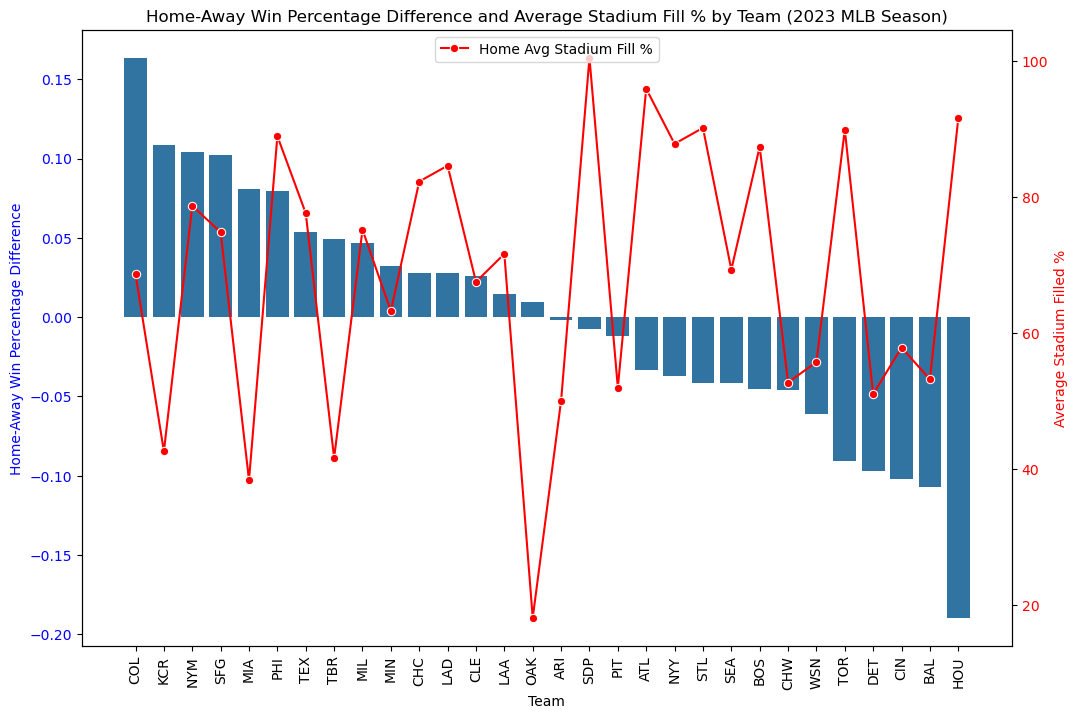

In [33]:
# Filter for home and away games
home_games = mlb_2023_cleaned[mlb_2023_cleaned['Home?'] == 'Y'].copy()
away_games = mlb_2023_cleaned[mlb_2023_cleaned['Home?'] == 'N'].copy()

# Add stadium capacity to the DataFrame for both home and away games, make numeric
home_games['Stadium Capacity'] = pd.to_numeric(home_games['Tm'].map(stadium_capacities))
away_games['Stadium Capacity'] = pd.to_numeric(away_games['Tm'].map(stadium_capacities))

# make attendance numeric
home_games['Attendance'] = pd.to_numeric(home_games['Attendance'])
away_games['Attendance'] = pd.to_numeric(away_games['Attendance'])

# Calculate percentage of the stadium filled for each game
home_games['Stadium Filled Percent'] = (home_games['Attendance'] / home_games['Stadium Capacity']) * 100
away_games['Stadium Filled Percent'] = (away_games['Attendance'] / away_games['Stadium Capacity']) * 100

# Group by team and calculate the home win percentage
home_win_percentage = home_games.groupby('Tm')['W/L'].value_counts().unstack()
home_win_percentage['Win Percentage'] = (home_win_percentage['W'] + home_win_percentage['W-wo']) / (home_win_percentage['W'] + home_win_percentage['W-wo'] + home_win_percentage['L'])

# Group by team and calculate the away win percentage
away_win_percentage = away_games.groupby('Tm')['W/L'].value_counts().unstack()
away_win_percentage['Win Percentage'] = (away_win_percentage['W']) / (away_win_percentage['W'] + away_win_percentage['L'])

# Calculate the difference between home and away win percentages
win_percentage_diff = home_win_percentage['Win Percentage'] - away_win_percentage['Win Percentage']

# Group by team to calculate the average attendance for home games
average_stadium_fill_home = home_games.groupby('Tm')['Stadium Filled Percent'].mean()

# Merge win percentage difference and average stadium fill into one DataFrame
team_stats = pd.DataFrame({
    'Win Percentage Diff': win_percentage_diff,
    'Avg Stadium Fill Home': average_stadium_fill_home,
})

# Sort the DataFrame by win percentage difference in descending order
team_stats = team_stats.sort_values(by='Win Percentage Diff', ascending=False)

# Create a subplot for both win percentage difference and average stadium fill
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot the win percentage difference
sns.barplot(x=team_stats.index, y=team_stats['Win Percentage Diff'], ax=ax1)
ax1.set_xlabel('Team')
ax1.set_ylabel('Home-Away Win Percentage Difference', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation=90)

# Create a secondary y-axis for the average stadium filled percentages for home and away games
ax2 = ax1.twinx()  # allows for dual axis
sns.lineplot(x=team_stats.index, y=team_stats['Avg Stadium Fill Home'], marker='o', color='red', ax=ax2, label='Home Avg Stadium Fill %')
ax2.set_ylabel('Average Stadium Filled %', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a legend
ax2.legend(loc='upper center')

# Suppress warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.title("Home-Away Win Percentage Difference and Average Stadium Fill % by Team (2023 MLB Season)")
plt.show()

Similar to the 2024 season, it appears that stadium fill percentage really doesn't impact home field advantage, and we may want to look at other factors. One thing that really stands out when comparing the two seasons to each other is that the Colorado Rockies are first in our home field advantage metric, and by a fairly significant margin, in 2023 and 2024. This could point to something else being an indicator of how well a team performs at home: Denver is known to be the highest altitude professional sports city, and players from other teams often say that it is difficult to play away games there because they don't get properly adjusted to the elevation levels. However, athletes that play for Denver based teams are much more acclimated to these elevation changes and thus could have a large competitive advantage over non Denver teams, which could explain the dominance of the Colorado Rockies in these visualizations. We will now investigate this across the other main sports leagues, the NFL, NBA, and NHL, to see how it compares.